In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Intro

Welcome to the BlendingToolKit (BTK) quickstart! This tutorial will guide you through the basic functionalities of BTK. If you are new to BTK, we recommend you to go through this notebook before moving on to the other tutorials.

We will show you how to generate a catalog of galaxy blends, draw images of these blends, use algorithms implemented within BTK (e.g. SExtractor) to deblend these images, and finally use metrics within BTK to assess the performance of the deblender.

# Setup

First, we will need to import the relevant python packages and modules:

In [ ]:
%matplotlib inline
import numpy as np
import os

In [ ]:
import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

# Drawing Blends

Before generating images of blends, we require some setup. 

**First**, we need to specify a catalog of galaxies to draw. We will use a subset of the CATSIM catalog, which contains `100` galaxies with realistic parameters.

BTK uses a wrapper class (e.g. `btk.catalog.CatsimCatalog`) to store information about the galaxy catalog you pass in. You can easily import the CATSIM catalog from a FITS file using the `from_file` method as demonstrated here with our example catalog:

In [ ]:
catalog_name = "../data/sample_input_catalog.fits"
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)
catalog.table[:5] # display 5 first entries of table containing the actual catalog information.

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab,ref_mag,btk_size
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2200871446,1505.9509277292,-0.5342399817876,0.496377289295,0.0,1.4144730572e-17,0.0,0.0,0.278649687767,0.0,0.221303001046,0.0,307.344329834,25.9418621063,25.129743576,23.9588813782,23.3607368469,23.0723800659,22.9095973969,23.3607368469,1.29850754499422
2205921112,1512.1024131744,-3.609359823168,1.89508104324,0.0,1.91501907101e-18,0.0,0.0,0.358063697815,0.0,0.313674807549,0.0,137.791702271,25.848903656,25.867565155,25.9179477692,25.9851398468,25.8779563904,25.7642536163,25.9851398468,1.6685768318179002
2205010878,1524.3564605652,-11.266919877384,1.93795013428,0.0,2.15612608955e-18,0.0,0.0,0.444279909134,0.0,0.424689114094,0.0,233.972427368,25.5657653809,25.5659580231,25.6165962219,25.6957893372,25.6281528473,25.5399188995,25.6957893372,2.07034437656444
2208734677,1515.910291668,-0.26135999942183996,1.16251754761,0.0,1.74001598433e-18,0.0,0.0,0.312852591276,0.0,0.180962398648,0.0,217.517120361,27.3159255981,27.4167633057,27.051820755,26.6737632751,25.9380722046,25.6458129883,26.6737632751,1.45789307534616
2212241881,1523.4518051136,-7.851959858088,1.35479903221,0.0,1.11031595423e-18,0.0,0.0,0.414316505194,0.0,0.205554202199,0.0,226.523849487,27.3325939178,27.4470024109,27.3282527924,27.0680370331,26.7419490814,26.1817016602,27.0680370331,1.93071491420404


**Second**, we require specifying a *sampling function*. The sampling function is a custom class within BTK that is used to determine which galaxies are drawn for each blend and what their locations within the blend should be. 

Specifically, we implement this functionality with the `SamplingFunction` class, which is a `callable` like a function. It takes as argument the astropy table contained within the `Catalog` object above, selects galaxies to be drawn in a given blend, and returns their (possibly modified) entries. Usually the `ra` and `dec` columns of these entries are modified to be relative to the center of the postage stamp containing the blend. 

For this tutorial, we will use the *default sampling function*, this function is implemented in the `btk.sampling_functions` module and is called `DefaultSampling`. This function draws a random number of galaxies from the catalog, uniformly distributed between 1 and `max_number`, and places them randomly within the postage stamp with some maximum shift `max_shift` w.r.t the center of the postage stamp.

The `DefaultSampling` function can be instantiated as follows:

In [ ]:
stamp_size = 24.0  # Size of the stamp, in arcseconds
max_number = 3     # Maximum number of galaxies in a blend
max_shift = 3.0    # Maximum shift of the galaxies, in arcseconds
seed = 1 # random seed for reproducibility purposes
sampling_function = btk.sampling_functions.DefaultSampling(max_number=max_number, stamp_size=stamp_size, max_shift=max_shift, seed = seed)

Here is an example output of the `DefaultSampling` function:

In [ ]:
blend_catalog = sampling_function(catalog.table)
blend_catalog # ra and dec are now relative to the center of the blend (not the original ones)

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab,ref_mag,btk_size
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2202277660,-2.135042323682198,-1.1290112879370873,1.1246805191,6.15615677509e-19,1.09819897835e-17,0.0,0.130108296871,2.49873948097,0.0865847021341,2.48218655586,89.9871063232,89.9871063232,30.0631866455,27.7341003418,25.7658348083,24.6860561371,23.8522891998,23.3242969513,24.6860561371,11.330954289694109
2200002241,2.6918966828234634,-0.4600413061645461,0.286700099707,5.92275188752e-16,2.6139930149e-15,0.0,0.72993272543,2.83298206329,0.723316073418,0.934578001499,179.033691406,179.033691406,20.3450546265,19.2668266296,18.2675285339,17.8270835876,17.5972328186,17.4129009247,17.8270835876,11.92895522428243


**Third**, we need to specify a *survey*. This will determine the pixel scale, sky level, and PSF of the images we will draw. 

BTK relies on the [galcheat](https://github.com/aboucaud/galcheat) package, which contains several `galcheat.survey.Survey` instances, which store the parameters for different surveys (including LSST, HSC, HST COSMOS...). The parameters represent physical parameters of the survey (mirror size, pixel scale). Each survey also contains several `galcheat.filter.Filter` objects with the parameters specific to each filter (exposure time, zeropoint). 

In BTK, we use the `btk.survey.Survey` class to store the survey parameters. This class is a wrapper around the `galcheat.survey.Survey` class, and contains additional information such as the PSF model.

For this tutorial, we will import the survey corresponding to LSST.

In [ ]:
LSST = btk.survey.get_surveys("LSST")

You can see the parameters of the survey by printing the `Survey` object:

In [ ]:
print(LSST)

--------
| LSST | Legacy Survey of Space and Time (LSST) done with the Simonyi survey telescope and the LSST camera
--------
  pixel_scale          = 0.2 arcsec
  mirror_diameter      = 8.36 m
  gain                 = 1.0 electron / adu
  obscuration          = 0.39257227
  zeropoint_airmass    = 1.2
  available_filters    = ['u', 'g', 'r', 'i', 'z', 'y']
  effective_area       = 33.342414830068996 m2


**Finally**, now that we have finished our setup, we can create the `DrawBlendsGenerator`. This object is a python `generator`, meaning it can be called with `next(generator)` to generate a new batch of blend catalogs and images. 

The `DrawBlendsGenerator` takes as arguments the `Catalog` object, the `SamplingFunction` object, and the `Survey` object. It also takes a few other arguments, such as the number of images to draw per batch, the size of the postage stamps, and the number of galaxies to draw per blend.

In [ ]:
# TODO: Link generator definition above to python documentation. 
draw_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    LSST,
    batch_size=100,
    stamp_size=stamp_size,
    cpus=1, # can use multiple cpu's to speed up image generation here. # TODO: `n_jobs` check GALSIM parallel processing??? 
    add_noise="all",
    seed=seed, # use same seed here
)

# generate batch 100 blend catalogs and images.
blend_batch = next(draw_generator)

Generating blends for LSST survey:   0%|          | 0/100 [00:00<?, ?it/s]

The output of the `DrawBlendsGenerator` is a class called `BlendBatch`, which contains the blend catalogs and images per survey specified. In this tutorial we are only using a single survey `LSST`, but several surveys can be used at the same time. See other tutorials for details. 

To access the blend images for a given survey, we can use the following syntax:

In [ ]:
blend_batch.LSST.blend_images.shape # shape = (batch_size, n_bands, stamp_size, stamp_size)

# TODO: structured array for numpy arrays. 
# TODO: Blend batch as class, avoid embedding the survey name into not rewriting your entire code.
# TODO: Consider making the parent class list object so you don't need to remember name
# TODO: list of simple classes. transparent and so no need to modify anything else in code if adding more surveys. 
# TODO: goal if copy paste notebook no to change it to HSC, only change 1 thing. 

(100, 6, 120, 120)

For the blended catalogs: 

In [ ]:
blend_batch.LSST.blend_list[0] # blend_list is a list of astropy tables, one for each blend in the batch.

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab,ref_mag,btk_size,x_peak,y_peak,not_drawn_u,not_drawn_g,not_drawn_r,not_drawn_i,not_drawn_z,not_drawn_y
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2200813818,0.29756212603835674,0.2288598793156691,0.350970596075,0.0,3.65527208395e-17,0.0,0.0,0.273549705744,0.0,0.0649354979396,0.0,71.0713500977,24.9696521759,24.2869358063,23.410484314,23.070728302,22.8698596954,22.7205543518,23.070728302,1.2747416287670401,60.98781063044967,60.644299396556384,0.0,0.0,0.0,0.0,0.0,0.0
2202484794,-2.83464532054159,-1.021609701005447,0.737505495548,0.0,6.11022188471e-18,0.0,0.0,0.403777301311,0.0,0.195289194584,0.0,232.21925354,26.6245307922,26.2098960876,25.5539073944,24.7192592621,24.4865779877,24.3074092865,24.7192592621,1.88160222410926,45.3267733962554,54.39195149443184,0.0,0.0,0.0,0.0,0.0,0.0
2200813818,1.521078652048839,1.7305722205704264,0.350970596075,0.0,3.65527208395e-17,0.0,0.0,0.273549705744,0.0,0.0649354979396,0.0,71.0713500977,24.9696521759,24.2869358063,23.410484314,23.070728302,22.8698596954,22.7205543518,23.070728302,1.2747416287670401,67.10539326039019,68.15286110313546,0.0,0.0,0.0,0.0,0.0,0.0


There is also additional information which you can inspect by printing the `BlendBatch` object. See other tutorials for more details.

In [ ]:
blend_batch # TODO: have type of latest nested type (see `psfs` below)

BlendBatch(batch_size = 100, max_n_sources = 3, stamp_size = 24.0), containing:
SurveyBatch(survey_name=LSST, 
	 blend_images: np.ndarray, shape [100, 6, 120, 120]
	 isolated_images: np.ndarray, shape [100, 3, 6, 120, 120]
	 blend_list: list of <class 'list'>, size 100
	 psfs: list of <class 'list'>, size 6
	 wcs: <class 'astropy.wcs.wcs.WCS'>)

We can proceed to drawing them by using the `btk.plot_utils` module.

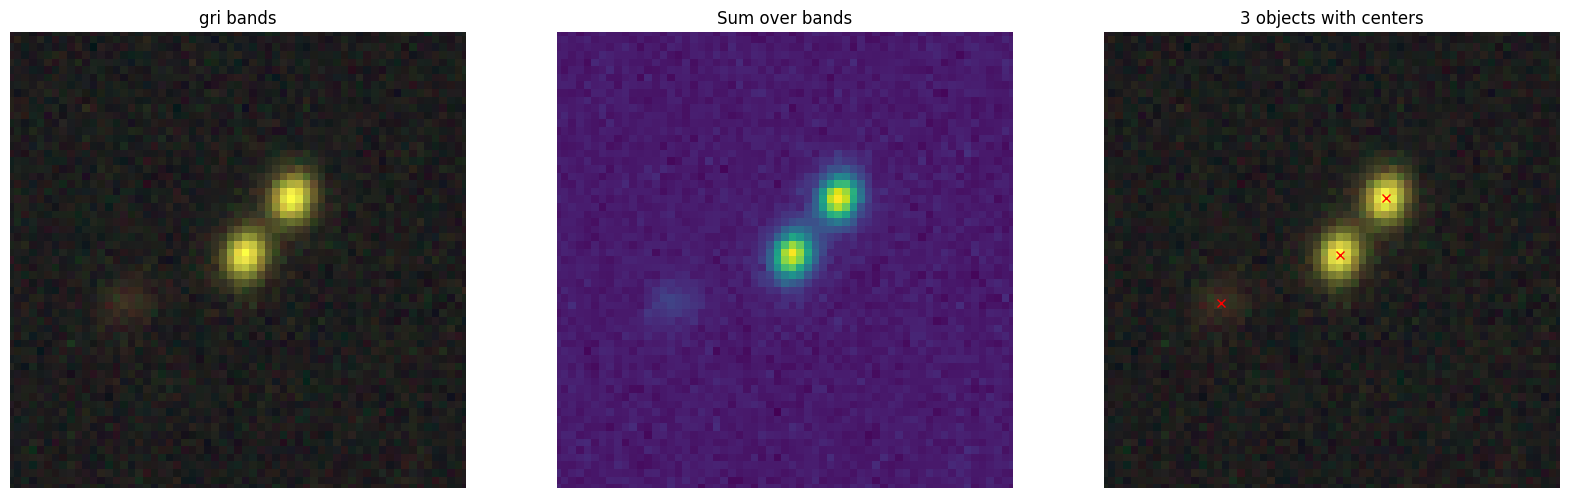

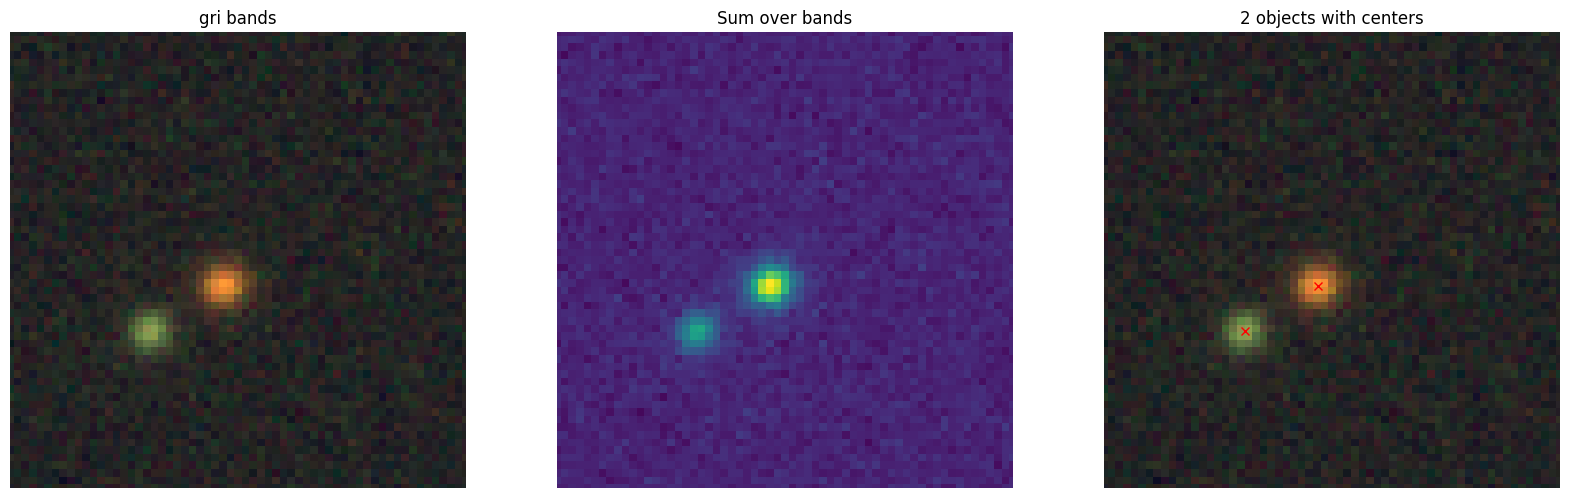

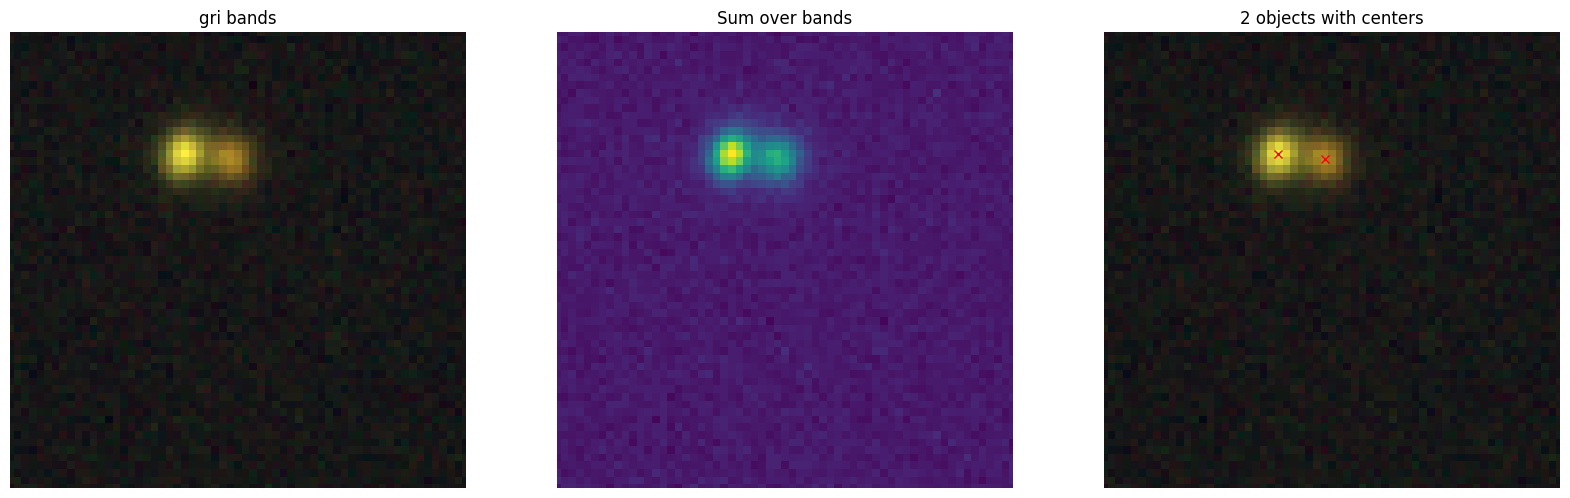

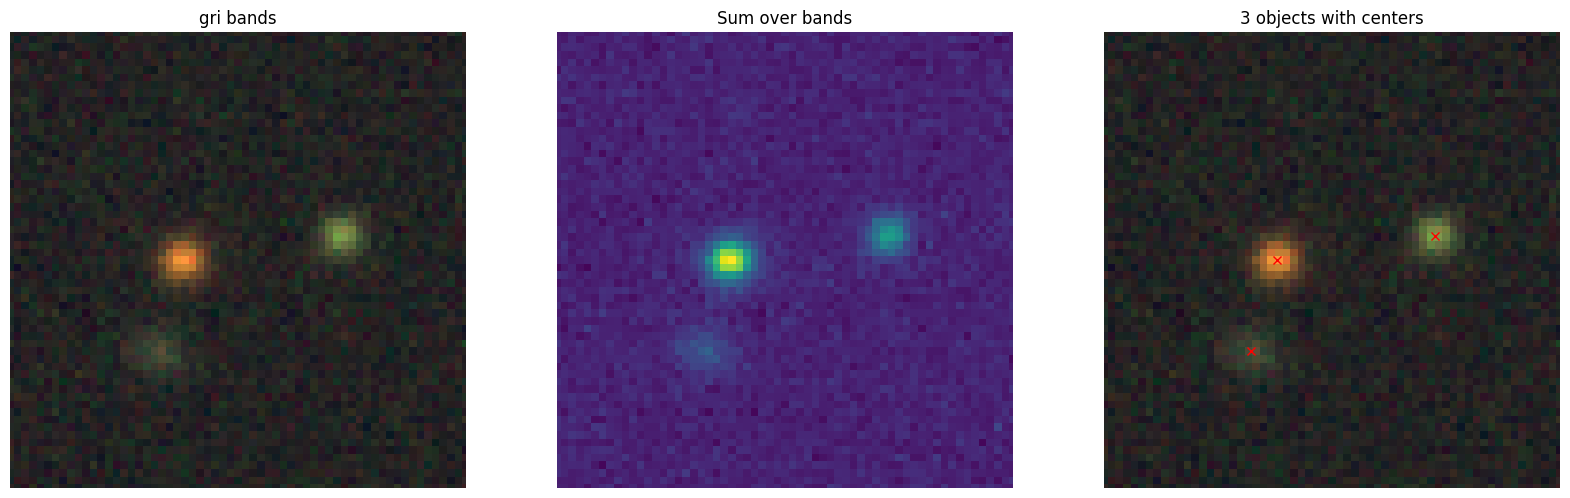

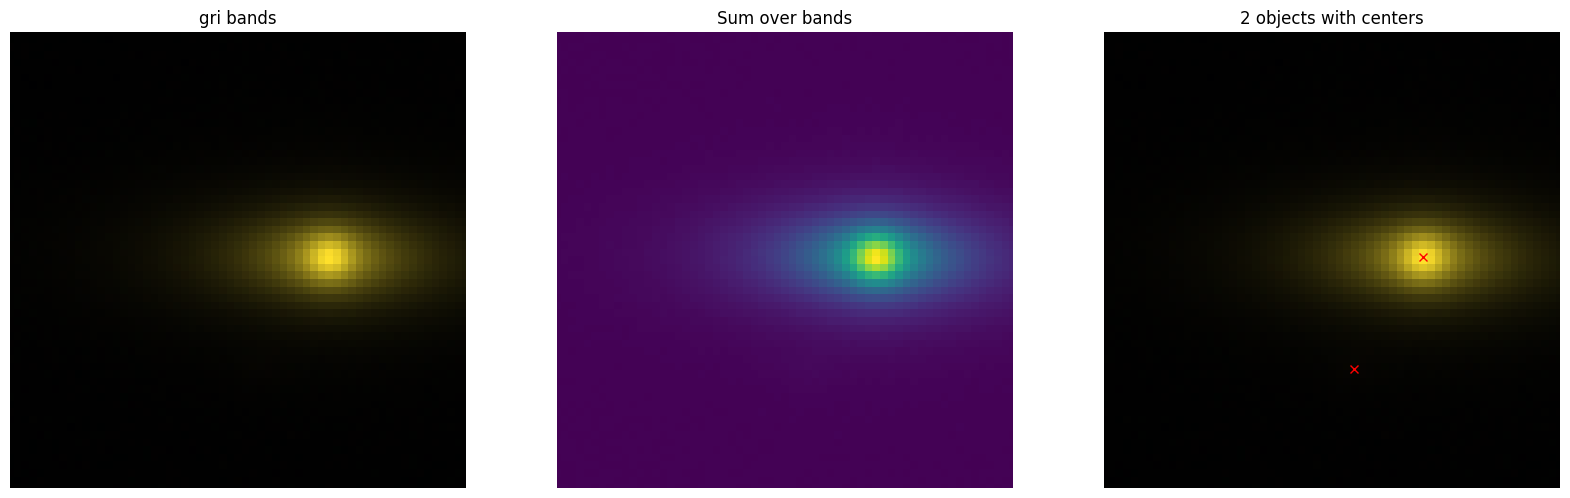

In [ ]:
# TODO: separate the imports -> so that users don't need to install all plotting packages. 
# look at dynesty example. 
# TODO: consider metric / deblend also could be good practice.
# TODO: rely on more existing plotting things, rather than write. 
# https://docs.astropy.org/en/stable/visualization/index.html (look at WCS and overplotting)
images = blend_batch.LSST.blend_images[:5]
catalogs = blend_batch.LSST.blend_list[:5]
btk.plot_utils.plot_blends(images, catalogs, limits=(30,90),norm="asinh",Q=0.1)

# Deblending

The next big part of BTK is the deblending. We will use the `Deblender` class to deblend the images we just drew. By 'deblending' we mean that we want to recover the individual galaxies that were blended together in the images. This includes recovering their positions, fluxes, and shapes.

In this tutorial we will use the `SExtractor` deblender, which is implemented in the `btk.deblender` module. Specifically the class `SepSingleband` is a wrapper around the [SEP](https://sep.readthedocs.io/en/v1.1.x/) package, which is a python implementation of the [SExtractor](https://www.astromatic.net/software/sextractor) algorithm.

Here is how we create the `Deblender` object:

In [ ]:
from btk.deblend import SepSingleband # TODO: band -> Band

In [ ]:
# TODO: same as `ngmix`, takes an Observation or list of Observations. 
# depending on what you provide handles the different cases
# don't give any name, if one survey or list of surveys, handles each separately (does it all). 
# https://github.com/esheldon/ngmix/blob/51c488b0914a4499b9372875576a463e2697b29d/ngmix/metacal/convenience.py#L98
# TODO: Add a separate option `reference`, it will hande every survey separately. 
# ut it will run only detection on `Euclid` and then run deblending on both using inputs. --> 'true_euclid', 'use_euclid'
# just duplicate the detections. 
# TODO: use true catalog? (extra option)
# TODO: Explicitly declare type of input, you are forced to having one type of input. (avoid different)
# find right balance between each specific function for each case. 
# TODO: MR specific enough to have its own class (make it explicit.) Have Deblender class have MR in the name. 
# For other case just reference catalog or not
deblender = SepSingleband('LSST', # outputs will correspond to this survey.
                          sigma_noise=1.5, 
                          use_band=2 # measure on 'r' band
                          )

You can use the `Deblender` object to deblend the images we drew earlier. The `Deblender` object takes as input the `BlendBatch` object, and returns a new `DeblenderBatch` object with the deblended images and/or catalogs.

In [ ]:
output = deblender(0, blend_batch) # deblend the first blend in the batch

0


Inspect output which is a `DeblendedExample` object. The output contains at least a `catalog` attribute, which in this case contains the locations for the deblended objects in the first blend of the batch.

In [ ]:
print(output)

MeasuredExample(max_n_sources = 3, stamp_size = 24.0, survey_name = LSST), containing: 
	catalog: <class 'astropy.table.row.Row'>
	segmentation: np.ndarray, shape [3, 120, 120]
	deblended_images: np.ndarray, shape [3, 120, 120]


In [ ]:
output.catalog

ra,dec
float64,float64
1295997.1513011523,-0.9687323171235325
0.3069107418261746,0.23507304473771218
1.5164788982144226,1.7108484048842771


There is also an option to run the deblender on the full batch with the `batch_call` method of any `Deblender` object. This method takes as input the `BlendBatch` object, and returns a new `DeblenderBatch` object with the deblended images and catalogs for each batch.

In [ ]:
batch_output = deblender.batch_call(blend_batch) # deblend the whole batch
batch_output

MeasuredBatch(batch_size = 100, max_n_sources = 3, stamp_size = 24.0, survey_name = LSST), containing: 
	catalog: list of <class 'astropy.table.table.Table'>, size 100
	segmentation: np.ndarray, shape [100, 3, 120, 120]
	deblended_images: np.ndarray, shape [100, 3, 120, 120]

You can access them as attributes of the `DeblenderBatch` object:

In [ ]:
batch_output.catalog[0] # predicted catalog for the first blend in the batch

ra,dec
float64,float64
1295997.1513011523,-0.9687323171235325
0.3069107418261746,0.23507304473771218
1.5164788982144226,1.7108484048842771


We provide a convenient way to automate the process of deblending using the `DeblenderGenerator` class. This class is a python `generator`, meaning it can be called with `next(generator)` to generate a new batch of deblended images and catalogs. Internally, it also calls the `DrawBlendsGenerator` to draw new batches of images.

This class is useful if you want to deblend a large number of images, and you don't want to store them all in memory at the same time. It is also helpful if you want to pass in multiple deblender simultaneously and compare their performance.

In [ ]:
from btk.deblend import DeblenderGenerator

deblender_generator = DeblenderGenerator(deblender, draw_generator, cpus=1)
blend_batch, deblend_output = next(deblender_generator)

Generating blends for LSST survey:   0%|          | 0/100 [00:00<?, ?it/s]

The output is a tuple, where the first entry is the `BlendBatch` directly from the `DrawBlendsGenerator`, and the second entry is a dictionary containing one key per `Deblender` passed with the output from the `batch_call` of the `Deblender` object (`DeblenderBatch`).

In [ ]:
deblend_output['SepSingleband']

MeasuredBatch(batch_size = 100, max_n_sources = 3, stamp_size = 24.0, survey_name = LSST), containing: 
	catalog: list of <class 'astropy.table.table.Table'>, size 100
	segmentation: np.ndarray, shape [100, 3, 120, 120]
	deblended_images: np.ndarray, shape [100, 3, 120, 120]

# Metrics

TBD... 